In [99]:
#استدعاء المكاتب
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [114]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Directories
train_path = "../../dataset/train"
test_path = "../../dataset/test"
 


class_names = ['Angry', 'Fear', 'Happy', 'Sad']

In [115]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(weights))


Found 1149 images belonging to 4 classes.
Found 487 images belonging to 4 classes.


In [117]:
# تحميل النموذج الأساسي بدون الطبقة العليا
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
 


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 684ms/step - accuracy: 0.5138 - loss: 1.2841 - val_accuracy: 0.5072 - val_loss: 1.2803 - learning_rate: 1.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 619ms/step - accuracy: 0.5894 - loss: 1.0783 - val_accuracy: 0.5503 - val_loss: 1.2325 - learning_rate: 1.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - accuracy: 0.6913 - loss: 0.7841 - val_accuracy: 0.5729 - val_loss: 1.3034 - learning_rate: 1.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - accuracy: 0.6889 - loss: 0.7392 - val_accuracy: 0.6674 - val_loss: 0.9047 - learning_rate: 1.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 612ms/step - accuracy: 0.7594 - loss: 0.6302 - val_accuracy: 0.6817 - val_loss: 0.8802 - learning_rate: 1.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 615ms/step - accuracy: 0.7898 - loss: 0.5618 - val_accuracy: 0.6982 - val_loss: 0.8511 - learning_rate: 1.0000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 616ms/step - acc

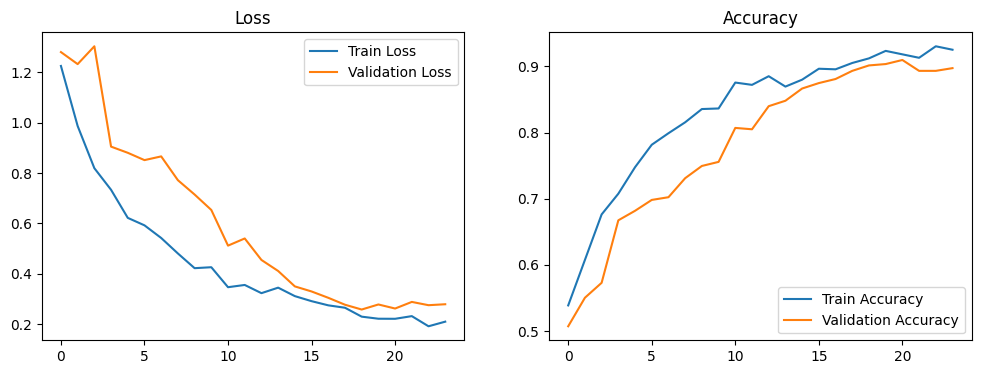

In [119]:
# Training
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

In [120]:
# Evaluation 
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%') 
print(f'Test Loss: {loss:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.8902 - loss: 0.2890
Test Accuracy: 90.14%
Test Loss: 0.2575


In [121]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
# تقرير تفصيلي
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step
              precision    recall  f1-score   support

       Angry       0.95      0.92      0.93       106
        Fear       0.90      0.80      0.84        98
       Happy       0.94      0.94      0.94       170
         Sad       0.82      0.92      0.87       113

    accuracy                           0.90       487
   macro avg       0.90      0.89      0.90       487
weighted avg       0.90      0.90      0.90       487



In [122]:
model.save('mobileNetV2_model.h5')